# Profile likelihood ratio calculator

Copyright (c) 2020, Pietro Vischia pietro.vischia@cern.ch


### Implementation of a class for profile likelihood calculations, with and without systematic uncertainties
Based on MINOS via iMinuit (Fred James' still rules)

Maybe in the future port to tensorflow?

##### Features
- [x] Profiling
- [x] Constraints on nuisance parameters
- [ ] Pulls and impacts
- [ ] Breakdown of systematic uncertainties


In [1]:
# Check profile likelihood
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy import optimize as op
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import sys

import random
import inspect
from iminuit import Minuit
import iminuit
print(iminuit.__version__)

1.5.4


In [30]:
class profile_likelihood_ratio():
    def __init__(self, model, data, ts, minuslogmodel=None, freezelist=None,nsteps=100, migradprecision=None):
        self.model = model
        self.minuslogmodel = minuslogmodel
        self.n_params=len(self.model.__code__.co_varnames)-2
        self.data = data
        self.ts=ts
        self.migradprecision= migradprecision
        self.constraints = {}
        self.initial_values=[1. for i in range(self.n_params)]
        #self.likelihood_realization=lambda params : -2*(self.model(self.ts(self.data), params))
        self.likelihood_realization=lambda params : (self.model(self.data, params))
        self.minusloglikelihood_realization= lambda params: 2*self.minuslogmodel(self.data, params) #if self.minuslogmodel else -2*np.log(self.model(self.data, params))
        # Work with variable names, to exploit <function>.__code__.co_varnames to have arbitrary number of variables
        self.pardict = { parname : 1 for parname in self.minuslogmodel.__code__.co_varnames if parname!='data' and parname!='params'} if self.minuslogmodel else { parname : 1 for parname in self.model.__code__.co_varnames if parname!='data' and parname!='params'}
        self.freezelist= freezelist if freezelist else { parname : [False, None] for parname in self.pardict.keys()}
        self.initial_values = [ 1. for i in range(self.n_params)]
        self.mles = None
        self.mleuncs = None
        self.nsteps = nsteps # For plotting
    def __call__(self, params):
        # I need the class to be callable, in order to call it. Sweet.
        return self.minusloglikelihood_realization(params)
        
    def minimize(self):
        # scipy.optimize.minimize is so crappy it drastically depends on the initial conditions
        #ret = op.minimize(self, self.initial_values, constraints=self.constraints )
        #m = Minuit(lambda theta, sigma : plr([theta, sigma]), 
        #             theta=self.initial_values[list(self.pardict.keys()).index('theta')],
        #             sigma=self.initial_values[list(self.pardict.keys()).index('sigma')])
        # Errordef should be 0.5 for -lnL, and 1 for least_squares, according to iminuit tutorial

        m = Minuit.from_array_func(plr, self.initial_values, name=self.pardict.keys(), errordef=1) 
        m.print_level=3
        for par, freezestatus in self.freezelist.items():
            print('par %s has freezestatus %s'%(par, freezestatus))
            if freezestatus[1] is not None:
                m.fitarg[par] = freezestatus[1] # Fix it to the input value
                m.values[par] = freezestatus[1]
                m.fitarg['error_%s'%par] = 0.
                print('I am freezing (conditioning on) parameter %s to %s'%(par, freezestatus[1]))
            if freezestatus[2]:
                m.fitarg[par] = freezestatus[1]
                m.values[par] = freezestatus[1]
                m.fitarg['error_%s'%par] = 1 
                
                print('I am settting the initial value of %s to %s and its variance to 1'%(par, 0))
            m.fitarg['fix_%s'%par] = freezestatus[0] # Freeze it
            m.fixed[par] = freezestatus[0]
            
    
            print('Minuit model settings:', m.fitarg)
            
        print('Final model settings: ', m.fitarg)
        if self.migradprecision:
            m.migrad(precision=self.migradprecision)
        else:
            m.migrad() # Minimize
        m.hesse()
        m.minos(sigma=1) # Compute asymmetric uncertainties (better than m.hesse() ). Fred James rulezzz
        
        
        #m.draw_profile(list(self.pardict.keys())[0],subtract_min=True);
        m.draw_mnprofile(list(self.pardict.keys())[0],subtract_min=True)                                                                                                                                                                                                                  
                                                                                 
        
        return [m.values, m.merrors] # when calling m.minos()
        #return [m.values, m.errors] # when calling m.hesse()
    def do_global_fit(self):
              
        results=self.minimize()
        print('Results', results)
        print('Best estimates', results[0])
        print('Uncertainties', results[1])
        self.mles = { par : results[0][par] for par in self.pardict.keys() }
        self.mleuncs = {}
        for par in self.pardict.keys():
            if self.freezelist[par][0] == False:
                self.mleuncs[par, +1] = results[1][par, +1.0]
                self.mleuncs[par, -1] = results[1][par, -1.0]

        for par, val in self.mles.items():
            if self.freezelist[par][0] == False:
                print('Parameter %s = %s (+%s/-%s) [fitted]'%(par,val, self.mleuncs[par, +1],self.mleuncs[par, -1]))
            else:
                print('Parameter %s = %s [frozen]'%(par,val))
    
    def compute_model_at(self, datapoint, pars):
        print(self.model(datapoint, pars))
        
    def plot_results(self, scan):
        pass
        
    def find_range_around_mle(self, par):
        mle = self.mles[par]
        # Wild guess, must find a more meaningful way (maybe pre-finding the range in which it's nonzero)
        return [mle+5*self.mleuncs[par, -1], mle+5*self.mleuncs[par, +1]] if self.freezelist[par][0] == False else [mle-5*abs(mle), mle+5*abs(mle)]
    
    def draw_data(self):
        fig = plt.figure(figsize=(10,10))
        plt.hist(self.data, bins=100)
        thepar=list(self.pardict.keys())[0] # Assume the location parameter is kind of the first parameter
        plt.axvline(x=self.ts(self.data), ls='--', c='red', label='Test statistic value')
        plt.axvline(x=self.mles[thepar], ls='--', c='black', label='Maximum likelihood estimate for location parameter theta')
        plt.axvspan(self.mles[thepar]+self.mleuncs[thepar, -1],self.mles[thepar]+self.mleuncs[thepar,+1], alpha=0.5, color='grey', label='68.3% CL interval')

        plt.legend(loc='best')
    def draw_likelihood(self, override_range=None):
        ret=[]
        # Draw the 1D likelihoods conditioned on the MLE of the N-1 parameters
        # also, for each parameter I plot around the MLE
        for par in self.pardict.keys():
            print('NOW PLOTTING %s'%par)
            par_idx = list(self.pardict.keys()).index(par)
            fig = plt.figure(figsize=(10,10))
            scanrange = self.find_range_around_mle(par)
            if override_range:
                if override_range[par]:
                    scanrange=override_range[par]

            # Pick the MLES for floating parameters, and the input values for the frozen ones
            theparams=[ [ j for j in self.initial_values] for i in range(self.nsteps) ]
            conditionlist = { conditionedpar : None for conditionedpar in self.pardict.keys() if conditionedpar!= par  }
            
            for i_params in range(self.nsteps):
                for mledpar in self.pardict.keys():
                    if mledpar != par:
                        mledpar_idx=list(self.pardict.keys()).index(mledpar)
                        theparams[i_params][mledpar_idx] = self.mles[mledpar] 
                        if self.freezelist[mledpar][0]:
                            theparams[i_params][mledpar_idx] = self.freezelist[mledpar][1]
                        conditionlist[mledpar] = theparams[i_params][mledpar_idx]
     
            print('Plotting %s in range %s in %s steps'%(par, scanrange, self.nsteps))            
            x=np.linspace(scanrange[0], scanrange[1], num=self.nsteps)
            
            for idx in range(self.nsteps):
                #print(idx, x[idx], theparams[idx][par_idx])
                theparams[idx][par_idx] = x[idx]
                #print('\t', idx, x[idx], theparams[idx][par_idx])


            y= [self(params) for params in theparams ]
            #print('Theparams', theparams)
            #for my_idx in range(self.nsteps):
            #    print(my_idx, theparams[my_idx], y[my_idx])
            #print('linspace x', x)
            plt.plot(x,y-np.nanmin(y), label='Delta ln(L) scan')
            plt.axvline(x=self.mles[par], ls='--', c='red', label='Maximum likelihood estimate')
            plt.axhline(y=1, c='blue', ls='--', alpha=0.5, label='68.3% CL')
            plt.axhline(y=4, c='blue', ls='--', alpha=0.5, label='95% CL')
            #1D: 1, 4; 2D: 2.29, 5.99)
            if self.freezelist[par][0] == False:
                plt.axvspan(self.mles[par]+self.mleuncs[par, -1],self.mles[par]+self.mleuncs[par,+1], alpha=0.5, color='grey', label='68.3% CL interval')
            plt.xlabel('Scan of %s while fixing %s'%(par, [[key, value] for key, value in conditionlist.items()]))
            plt.ylabel('Delta ln(L)')
            plt.ylim(-1,10)
            plt.legend(loc='best')
            ret.append(fig)
        return ret
        
    def print_inputs(self, alsoData=False):
        if(alsoData):
            print('Data:')
            print(data)
        print('Test statistic: ')
        print(self.ts)
        print('Test statistic value:')
        print(self.ts(self.data))
        print('Parameters:')
        print(self.model.__code__.co_varnames)
        print('Parameters dictionary:')
        print(self.pardict)
        print('Initial values:')
        print(self.initial_values)
        print('Model:')
        print(inspect.getsource(self.model))
        print('Likelihood model (fixed data):')
        print(inspect.getsource(self.likelihood_realization))
        print('Likelihood model parameters:')
        print(self.likelihood_realization.__code__.co_varnames)
        print('minus-log-Likelihood model (fixed data):')
        print(inspect.getsource(self.minusloglikelihood_realization))
        print('minus-log-Likelihood model parameters:')
        print(self.minusloglikelihood_realization.__code__.co_varnames)
        #print(self.model)


In [ ]:
# First let's start with a gaussian likelihood
def my_gaussian_likelihood(data, params):
    theta=params[0]
    sigma=params[1]
    return 1./(math.sqrt(2*math.pi)*sigma)*math.exp(-((data-theta)**2/sigma**2).sum())
    #return 1./(math.sqrt(2*math.pi)*sigma)*math.exp(-1*argument)
    #return 1./(math.sqrt(2*math.pi)*sigma)*math.exp(-(data-theta)**2/sigma**2)

def my_gaussian_minusloglikelihood(data, params):
    theta=params[0]
    sigma=params[1]
    return np.log(math.sqrt(2*math.pi)*sigma) + ((data-theta)**2/sigma**2).sum()
    

Ntot=10000
data = np.array([ random.gauss(5,2) for i in range(Ntot)])
debug=True

plr = profile_likelihood_ratio(my_gaussian_likelihood, data, np.mean, my_gaussian_minusloglikelihood)

if debug:
    plr.print_inputs()
plr.do_global_fit()

TypeError: 'NoneType' object is not subscriptable

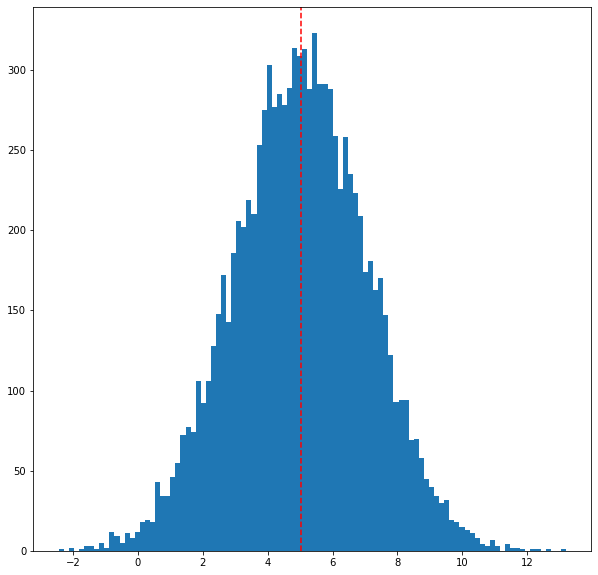

In [43]:
figs = plr.draw_data()

plt.show()


figs = plr.draw_likelihood({'theta' : None, 'sigma' : None})

for fig in figs:
    plt.show()

#x = np.linspace(0,10)
#y = [ my_gaussian_likelihood(data[0], [x_i, 1]) for x_i in x]
#plt.plot(x, y)
#plt.show()

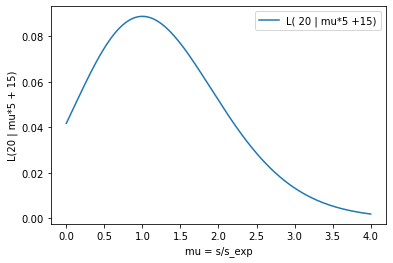

In [28]:
# First let's have one bin (channel) and check it works
def my_poisson_count_model_1bin_nonuisance(data, params):
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    return st.poisson(mu*s+b).pmf(data) 
    #poisson_part = st.poisson(mu*s+b)
    #p_nobs_given_exp =poisson_part.pmf(data) # this is pois(Nobs | mu*s + b)
    #ret=p_nobs_given_exp
    #return ret

def my_poisson_count_model_1bin_nonuisance_minusloglikelihood(data, params): # analytical loglikelihood better computationally (small values)
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    ret= mu*s+b - data*np.log(mu*s+b)
    return ret


Nobs=20
sexp=5
bexp=15

#print(inspect.getsource(my_marked_poisson_model_1bin_nonuisance))

x=np.linspace(0,4, num=200) # scan mu
y = [ my_poisson_count_model_1bin_nonuisance( Nobs, [x_i, sexp, bexp] ) for x_i in x  ]

plt.plot(x,y, label='L( %s | mu*%s +%s)' %(Nobs, sexp, bexp))
plt.xlabel('mu = s/s_exp')
plt.ylabel('L(%s | mu*%s + %s)'%(Nobs, sexp, bexp))
plt.legend(loc='best')
plt.show()



10 10 10


Text(0.5, 0, 'Expected signal sexp')

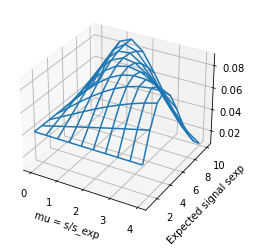

In [29]:

fig = plt.figure()
ax = fig.gca(projection='3d')

yy = np.linspace(1,10, num=10) # scan sexp
xx = np.linspace(0,4, num=10) # scan mu
zz = np.zeros( (xx.size, yy.size) )
counter_y = 0
for X in xx:
    counter_x = 0
    for Y in xx:
        zz[counter_x,counter_y] = my_poisson_count_model_1bin_nonuisance(Nobs, [X, Y, bexp])
        counter_x += 1
    counter_y += 1
#zz=[ [ my_marked_poisson_model_1bin_nonuisance(Nobs, [X, Y, bexp]) for Y in yy ] for X in xx]
print(len(xx), len(yy), len(zz))
X, Y = np.meshgrid(xx,yy)
#zz = my_marked_poisson_model_1bin_nonuisance( Nobs, [X, Y, bexp] ) 
#mmpm1n = np.vectorize(my_marked_poisson_model_1bin_nonuisance)
#zz= mmpm1n( Nobs, [X, Y, bexp])
#print(my_marked_poisson_model_1bin_nonuisance( Nobs, [0.88888889, 3, bexp] ) )
#zz = [ my_marked_poisson_model_1bin_nonuisance( Nobs, [xx_i, yy_i, bexp] ) for xx_i, yy_i in zip(X, Y) ]
ax.plot_wireframe(X, Y, zz )
ax.set_xlabel('mu = s/s_exp')
ax.set_ylabel('Expected signal sexp')
#ax.set_zlim(0, 0.0000001)
#Nobs=45
#debug=True

#plr = profile_likelihood_ratio(my_gaussian_likelihood, data, np.mean, my_gaussian_minusloglikelihood)

#if debug:
#    plr.print_inputs()
#plr.do_global_fit()

Test statistic: 
<function mean at 0x7fd9ac448790>
Test statistic value:
20.0
Parameters:
('data', 'params', 'mu', 's', 'b')
Parameters dictionary:
{'mu': 1, 's': 1, 'b': 1}
Initial values:
[1.0, 1.0, 1.0]
Model:
def my_poisson_count_model_1bin_nonuisance(data, params):
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    return st.poisson(mu*s+b).pmf(data) 

Likelihood model (fixed data):
        self.likelihood_realization=lambda params : (self.model(self.data, params))

Likelihood model parameters:
('params',)
minus-log-Likelihood model (fixed data):
        self.minusloglikelihood_realization= lambda params: 2*self.minuslogmodel(self.data, params) if self.minuslogmodel else -2*np.log(self.model(self.data, params))

minus-log-Likelihood model parameters:
('params',)
I am freezing (conditioning on) parameter s to 5
I am freezing (conditioning

<ipython-input-2-b7a7a5d829bc>:63: DeprecationWarning: `merrors[(name, +-1)]` is deprecated; use `merrors[name]`
  self.mleuncs[par, +1] = results[1][par, +1.0]
<ipython-input-2-b7a7a5d829bc>:64: DeprecationWarning: `merrors[(name, +-1)]` is deprecated; use `merrors[name]`
  self.mleuncs[par, -1] = results[1][par, -1.0]


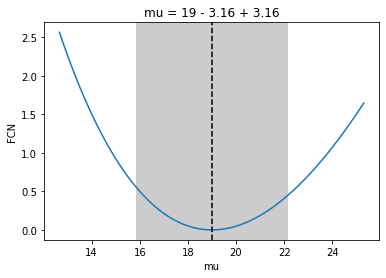

In [30]:
# Now try profile likelihood ratio routine with this simple model
Ntot=1000
data = st.poisson.rvs(20, size=Ntot)
data = 20
debug=True


freezelist = {'mu': [False, None],
              's': [True, 5],
              'b': [True, 15]}

plr = profile_likelihood_ratio(my_poisson_count_model_1bin_nonuisance, data, np.mean, my_poisson_count_model_1bin_nonuisance_minusloglikelihood, freezelist)

if debug:
    plr.print_inputs()
plr.do_global_fit()

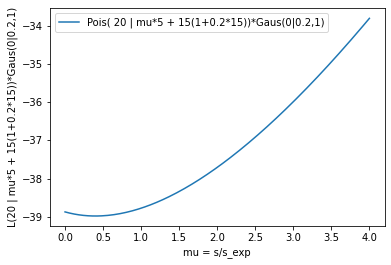

IndexError: list index out of range

In [16]:
# Now let's try to add a nuisance parameter.



# First let's have one bin (channel) and check it works
def my_poisson_count_model_1bin(data, params):
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    bunc=params[3] # We will profile this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    pois_term = st.poisson.pmf(data,mu*s+b*(1.+bunc))
    #pois_term= ((mu*s+b*(1.+bunc))**data)*np.exp(-(mu*s+b*(1.+bunc)))/math.factorial(data)
    #constraint_term = 1./(math.sqrt(2*math.pi)*bunc)*math.exp(-((data-b)**2/bunc**2))
    constraint_term=st.norm.pdf(0, b , 1)
    #print(pois_term, constraint_term)
    #joint_pdf = np.outer(pois_term, constraint_term)
    #print(pois_term)
    #print(constraint_term)
    return pois_term*constraint_term

    #poisson_part = st.poisson(mu*s+b)
    #p_nobs_given_exp =poisson_part.pmf(data) # this is pois(Nobs | mu*s + b)
    #ret=p_nobs_given_exp
    #return ret


def my_poisson_count_model_1bin_minusloglikelihood(data, params): # analytical loglikelihood better computationally (small values)
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    bunc=params[3] # We will profile this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    #print(mu*s, b*(1.+bunc), mu*s+b*(1.+bunc),math.sqrt(2*math.pi)*bunc)
    #print(mu, s, b, bunc)
    return mu*s+b*(1.+bunc) - data*np.log(mu*s+b*(1.+bunc)) + 0.5*np.log(2*math.pi) + 0.5*(bunc**2)


Nobs=20
sexp=5
bexp=15
bunc=0.2
#print(inspect.getsource(my_marked_poisson_model_1bin_nonuisance))

x=np.linspace(0,4, num=200) # scan mu


y = [ my_poisson_count_model_1bin_minusloglikelihood( Nobs, [x_i, sexp, bexp, bunc] ) for x_i in x  ]
#y = my_poisson_count_model_1bin(Nobs, [x, sexp, bexp, bunc])
plt.plot(x,y, label='Pois( %s | mu*%s + %s(1+%s*%s))*Gaus(0|%s,1)' %(Nobs, sexp, bexp, bunc, bexp, bunc))
plt.xlabel('mu = s/s_exp')
plt.ylabel('L(%s | mu*%s + %s(1+%s*%s))*Gaus(0|%s,1)'%(Nobs, sexp, bexp, bunc, bexp,bunc))
#plt.ylim(0,0.12)
plt.legend(loc='best')
plt.show()


y2 = [ my_poisson_count_model_1bin( Nobs, [x_i, sexp, bexp] ) for x_i in x  ]
plt.plot(x,y2, label='Pois( %s | mu*%s + %s)' %(Nobs, sexp, bexp))
plt.xlabel('mu = s/s_exp')
plt.ylabel('L(%s | mu*%s + %s)'%(Nobs, sexp, bexp))
plt.ylim(0,0.12)
plt.legend(loc='best')
plt.show()


Test statistic: 
<function mean at 0x7f2ed45dd790>
Test statistic value:
50.0
Parameters:
('data', 'params', 'mu', 's', 'b', 'bunc', 'pois_term', 'constraint_term')
Parameters dictionary:
{'mu': 1, 's': 1, 'b': 1, 'bunc': 1}
Initial values:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Model:
def my_poisson_count_model_1bin(data, params):
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    bunc=params[3] # We will profile this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    pois_term = st.poisson.pmf(data,mu*s+b*(1.+bunc))
    #pois_term= ((mu*s+b*(1.+bunc))**data)*np.exp(-(mu*s+b*(1.+bunc)))/math.factorial(data)
    #constraint_term = 1./(math.sqrt(2*math.pi)*bunc)*math.exp(-((data-b)**2/bunc**2))
    constraint_term=st.norm.pdf(0, b , 1)
    #print(pois_term, constraint_term)
    #joint_pdf = np.outer(pois_term, constraint_term)
    #print(pois_term)
    #print(constraint_term)
    return pois_term*

<ipython-input-30-f1d8a92e6e2b>:34: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  m.print_level=3
<ipython-input-30-f1d8a92e6e2b>:64: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  m.draw_mnprofile(list(self.pardict.keys())[0],subtract_min=True)
<ipython-input-30-f1d8a92e6e2b>:79: DeprecationWarning: `merrors[(name, +-1)]` is deprecated; use `merrors[name]`
  self.mleuncs[par, +1] = results[1][par, +1.0]
<ipython-input-30-f1d8a92e6e2b>:80: DeprecationWarning: `merrors[(name, +-1)]` is deprecated; use `merrors[name]`
  self.mleuncs[par, -1] = results[1][par, -1.0]
<ipython-input-16-e7c04b7dc211>:36: RuntimeWarning: invalid value encountered in log
  return mu*s+b*(1.+bunc) - data*np.log(mu*s+b*(1.+bunc)) + 0.5*np.log(2*math.pi) + 0.5*(bunc**2)
<ipython-input-16-e7c04b7dc211>:36: RuntimeWarning: invalid value encountered in log
  return mu*s+b*(1.+b

[<Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>]

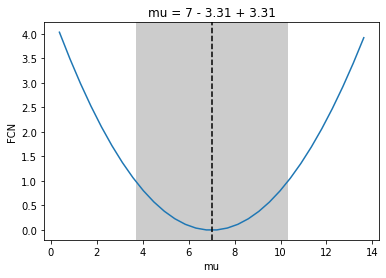

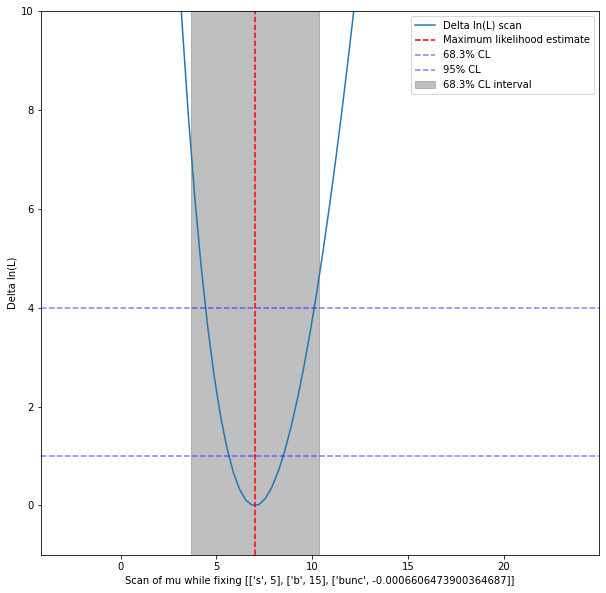

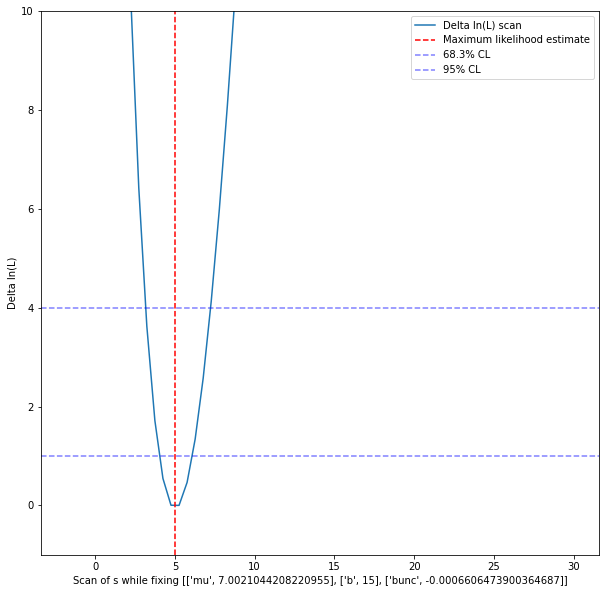

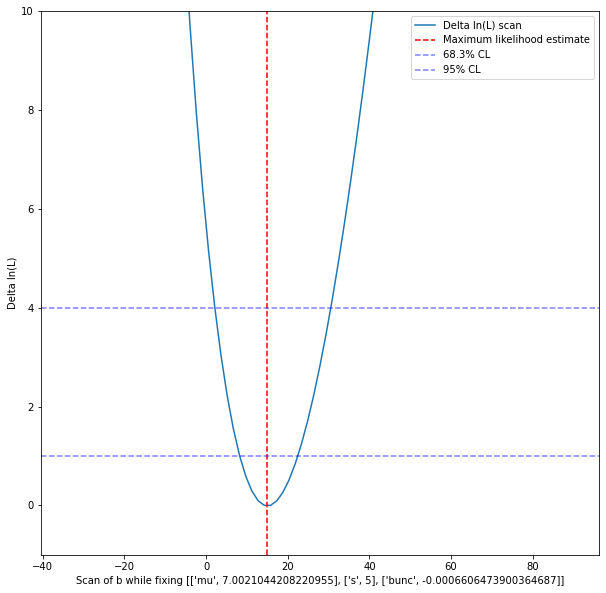

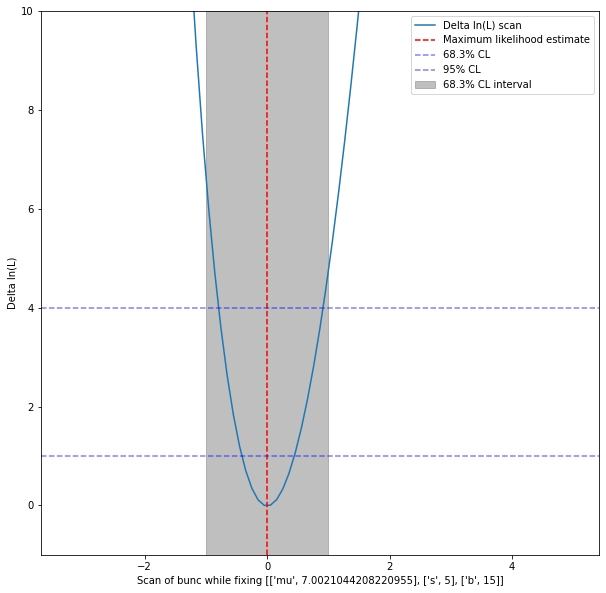

In [31]:
Ntot=1000
#data = st.poisson.rvs(20, size=Ntot)

debug=True

data = 50
sexp=5
bexp=15
bunc=0.0002

freezelist = {'mu': [False, None, False],
              's': [True, sexp, False],
              'b': [True, bexp, False],
              'bunc': [False,bunc, True]}

plr = profile_likelihood_ratio(my_poisson_count_model_1bin, data, np.mean, minuslogmodel=my_poisson_count_model_1bin_minusloglikelihood, freezelist=freezelist,migradprecision=0.0001)
#migradprecision=0.1
if debug:
    plr.print_inputs()
plr.do_global_fit()
plr.draw_likelihood()

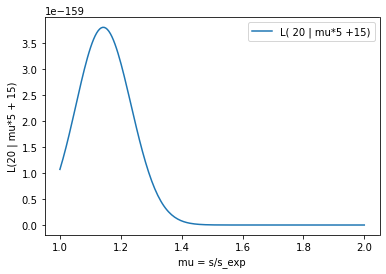

In [10]:
# First let's have one bin (channel) and check it works
def my_marked_poisson_model_1bin_nonuisance(data, params):
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    poisson_part = st.poisson(mu*s+b)
    f_observable = st.poisson(mu*s+b)
    p_nobs_given_exp =poisson_part.pmf(len(data)) # this is pois(Nobs | mu*s + b)
    prod_p_ev_give_exp = np.array([ f_observable.pmf(d) for d in data]).prod() # this is prod(f(x_i|mu))
    #print(mu, s, b, p_nobs_given_exp, prod_p_ev_give_exp, p_nobs_given_exp*prod_p_ev_give_exp)
    ret=p_nobs_given_exp*prod_p_ev_give_exp
    #print('Returning %s'%ret)
    return ret

def my_marked_poisson_model_1bin_nonuisance_minusloglikelihood(data, params): # analytical loglikelihood better computationally (small values)
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    poisson_part = st.poisson(mu*s+b)
    p_nobs_given_exp =poisson_part.pmf(data) # this is pois(Nobs | mu*s + b)
    prod_p_ev_give_exp = np.array([ poisson_part.pmf(d) for d in range(data)]).prod() # this is prod(f(x_i|mu))
    #print(mu, s, b, p_nobs_given_exp, prod_p_ev_give_exp, p_nobs_given_exp*prod_p_ev_give_exp)
    ret=p_nobs_given_exp*prod_p_ev_give_exp
    #print('Returning %s'%ret)
    return ret


Ntot=100
#observations = np.array([ random.gauss(5, 1) for i in range(Ntot)])
observations = st.poisson.rvs(20, size=Ntot)
Nobs=20
sexp=5
bexp=15

#print(inspect.getsource(my_marked_poisson_model_1bin_nonuisance))

x=np.linspace(1,2, num=200) # scan mu
y = [ my_marked_poisson_model_1bin_nonuisance( observations, [x_i, sexp, bexp] ) for x_i in x  ]

plt.plot(x,y, label='L( %s | mu*%s +%s)' %(Nobs, sexp, bexp))
plt.xlabel('mu = s/s_exp')
plt.ylabel('L(%s | mu*%s + %s)'%(Nobs, sexp, bexp))
plt.legend(loc='best')
plt.show()

Test statistic: 
<function mean at 0x7fd9ac448790>
Test statistic value:
20.0
Parameters:
('data', 'params', 'mu', 's', 'b')
Parameters dictionary:
{'mu': 1, 's': 1, 'b': 1}
Initial values:
[1.0, 1.0, 1.0]
Model:
def my_poisson_count_model_1bin_nonuisance(data, params):
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    return st.poisson(mu*s+b).pmf(data) 

Likelihood model (fixed data):
        self.likelihood_realization=lambda params : (self.model(self.data, params))

Likelihood model parameters:
('params',)
minus-log-Likelihood model (fixed data):
        self.minusloglikelihood_realization= lambda params: 2*self.minuslogmodel(self.data, params) if self.minuslogmodel else -2*np.log(self.model(self.data, params))

minus-log-Likelihood model parameters:
('params',)
I am freezing (conditioning on) parameter s to 5
I am freezing (conditioning

<ipython-input-2-b7a7a5d829bc>:63: DeprecationWarning: `merrors[(name, +-1)]` is deprecated; use `merrors[name]`
  self.mleuncs[par, +1] = results[1][par, +1.0]
<ipython-input-2-b7a7a5d829bc>:64: DeprecationWarning: `merrors[(name, +-1)]` is deprecated; use `merrors[name]`
  self.mleuncs[par, -1] = results[1][par, -1.0]


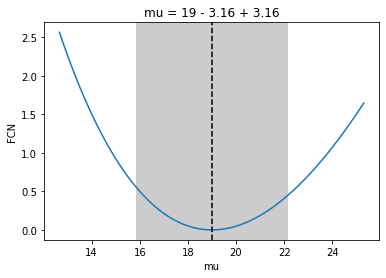

In [15]:
Ntot=1000
data = st.poisson.rvs(20, size=Ntot)
data = 20
debug=True


freezelist = {'mu': [False, None],
              's': [True, 5],
              'b': [True, 15]}

plr = profile_likelihood_ratio(my_poisson_count_model_1bin, data, np.mean, my_poisson_count_model_1bin_nonuisance_minusloglikelihood, freezelist)

if debug:
    plr.print_inputs()
plr.do_global_fit()

In [16]:
d = {'asd' : 3, 'as' : 4}

In [17]:
print(d)

{'asd': 3, 'as': 4}


In [18]:
d.keys()

dict_keys(['asd', 'as'])

In [26]:
list(d.keys())[0]

'asd'

In [16]:

def my_poisson_count_model_1bin_minusloglikelihood(data, params): # analytical loglikelihood better computationally (small values)
    mu=params[0] # POI
    s=params[1] # We will condition on this
    b=params[2] # We will condition on this
    #bunc=params[3] # We will profile this
    # Now mu is the POI, while s and b will be conditioned upon (expected counts)
    
    ret= mu*s+b*(1.+bunc) - data*np.log(mu*s+b*(1.+bunc))
    #+ np.log(math.sqrt(2*math.pi)*bunc) + ((data-theta)**2/sigma**2).sum()
    return ret

class MemoizedMinuit:
    """This class avoids repeated computation of the same intervals, which only depend on k."""

    def __init__(self, nll):
        self._results = {}

    def __call__(self, k):
        r = self._results.get(k, None)
        if r is None:

            def nll(lambd):
                return lambd - k * np.log(lambd)

            m = Minuit(nll, lambd=k + 1)
            m.limits["lambd"] = (0, None)
            m.errordef = Minuit.LIKELIHOOD
            m.migrad()
            m.hesse()
            m.minos()
            assert m.valid

            p = m.values["lambd"]
            dp = m.errors["lambd"]
            pm = max(p + m.merrors["lambd"].lower, 0.0), p + m.merrors["lambd"].upper

            r = p, dp, *pm
            self._results[k] = r

        return r
m = Minuit(my_poisson_count_model_1bin_minusloglikelihood, lambd=k + 1)
m.limits["lambd"] = (0, None)
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
m.minos()
assert m.valid



NameError: name 'k' is not defined